# Pytorch FFNN test notebook

**Imports**

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

**Define initial parameters**

In [2]:
input_size = 784 # 28x28, because MNIST images are 28x28
hidden_size = 100 # number of nodes in hidden layer
num_classes = 10 # number of classes, 0-9
num_epochs = 2 # number of times we go through the entire dataset
batch_size = 100 # number of samples in one forward/backward pass
learning_rate = 0.001 # learning rate

In [5]:
# Device configuration, this is to check if GPU is available and run on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# MNIST dataset (images and labels)
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, 
                                           transform=transforms.ToTensor(), download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, 
                                          transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, 
                                          shuffle=False)

# look at one batch of images
examples = iter(test_loader) # create iterable object
samples, labels = next(examples)  # unpack the batch
print(f'Shape of samples: {samples.shape}, shape of labels: {labels.shape}')

100.0%
100.0%
100.0%
100.0%

Shape of samples: torch.Size([100, 1, 28, 28]), shape of labels: torch.Size([100])


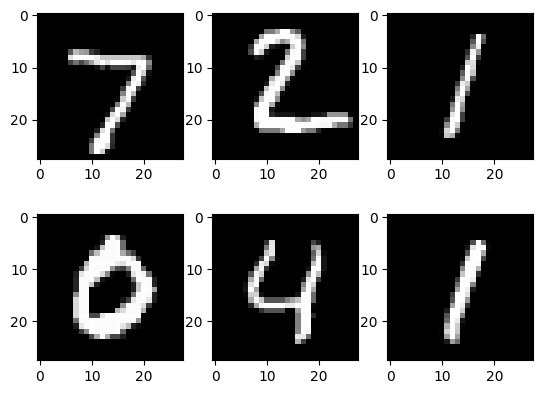

In [4]:
# make a plot
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(samples[i][0], cmap='gray')
plt.show()

In [6]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet,self).__init__()
        self.l1 = nn.Linear(input_size,hidden_size) # first layer
        self.relu = nn.ReLU() # activation function
        self.l2 = nn.Linear(hidden_size,num_classes) # second layer

    def forward(self,x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out
    
model = NeuralNet(input_size,hidden_size,num_classes).to(device)

In [7]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [12]:
# training loop
n_total_steps = len(train_loader) # number of batches in training set

for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        # reshape images to (batch_size, input_size)
        # 100,1,28,28 -> 100,784
        images = images.reshape(-1,28*28).to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs,labels)

        # backward pass
        optimizer.zero_grad() # set gradients to zero
        loss.backward()     # backpropagation
        optimizer.step()   # update weights

        if (i+1) % 100 == 0: # print every 100 steps
            print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')

print('Finished training')

epoch 1/2, step 100/600, loss = 0.0469
epoch 1/2, step 200/600, loss = 0.0615
epoch 1/2, step 300/600, loss = 0.1191
epoch 1/2, step 400/600, loss = 0.0949
epoch 1/2, step 500/600, loss = 0.1003
epoch 1/2, step 600/600, loss = 0.0410
epoch 2/2, step 100/600, loss = 0.1857
epoch 2/2, step 200/600, loss = 0.0568
epoch 2/2, step 300/600, loss = 0.0773
epoch 2/2, step 400/600, loss = 0.0963
epoch 2/2, step 500/600, loss = 0.0522
epoch 2/2, step 600/600, loss = 0.0633
Finished training


In [13]:
# test the model
with torch.no_grad(): # we don't need gradients in the testing phase
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1,28*28).to(device)    # 100,1,28,28 -> 100,784
        labels = labels.to(device)                    # 100,1 -> 100
        outputs = model(images)                     # 100,10

        # value, index
        _, predictions = torch.max(outputs,1) # 1 is the dimension
        n_samples += labels.shape[0] # number of samples in the current batch
        n_correct += (predictions == labels).sum().item()  # number of correct predictions

    acc = 100.0 * n_correct / n_samples  # accuracy
    print(f'accuracy = {acc}')

accuracy = 97.46
